In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [ ]:
data = pd.read_csv("train.csv")

In [ ]:
data.shape

(19999, 4)

In [ ]:
data.head()

,Unnamed: 0,text,subject,target
0,0,new york reuters us environmental group sierra...,politicsNews,TRUE
1,1,washington reuters us air force asked industry...,politicsNews,TRUE
2,2,saturday paul ryan posted photo instagram phot...,News,Fake
3,3,america keeps waiting word hillary indicted ob...,politics,Fake
4,4,religion peace ht weasel zippers,left-news,Fake


In [ ]:
data.dtypes

Unnamed: 0    object
text          object
subject       object
target        object
dtype: object

## Data cleaning and preparation

In [ ]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [ ]:
# Check the data
data.head()

,Unnamed: 0,text,subject,target
0,1377,rome reuters leader italy farright northern le...,worldnews,TRUE
1,17667,probably big misunderstanding bill likely miss...,politics,Fake
2,8089,reuters president donald trump opened door tue...,politicsNews,TRUE
3,18957,former senate president haiti bernard sansaric...,politics,Fake
4,13317,france armed police officers least prepared ha...,politics,Fake


In [ ]:
# Removing the date (we won't use it for the analysis)
data.drop(["subject"],axis=1,inplace=True)
data.head()

,Unnamed: 0,text,target
0,1377,rome reuters leader italy farright northern le...,TRUE
1,17667,probably big misunderstanding bill likely miss...,Fake
2,8089,reuters president donald trump opened door tue...,TRUE
3,18957,former senate president haiti bernard sansaric...,Fake
4,13317,france armed police officers least prepared ha...,Fake


In [ ]:
data.drop(["Unnamed: 0"],axis=1,inplace=True)
data.head()

,text,target
0,rome reuters leader italy farright northern le...,TRUE
1,probably big misunderstanding bill likely miss...,Fake
2,reuters president donald trump opened door tue...,TRUE
3,former senate president haiti bernard sansaric...,Fake
4,france armed police officers least prepared ha...,Fake


In [ ]:
data['text'] = data['text'].str.lower()
data.head()

,text,target
0,rome reuters leader italy farright northern le...,TRUE
1,probably big misunderstanding bill likely miss...,Fake
2,reuters president donald trump opened door tue...,TRUE
3,former senate president haiti bernard sansaric...,Fake
4,france armed police officers least prepared ha...,Fake


In [ ]:
data['target'] = data['target'].str.lower()
data.head()

,text,target
0,rome reuters leader italy farright northern le...,true
1,probably big misunderstanding bill likely miss...,fake
2,reuters president donald trump opened door tue...,true
3,former senate president haiti bernard sansaric...,fake
4,france armed police officers least prepared ha...,fake


In [ ]:
# Check
data.head()

,text,subject,target
0,university of michigan is located in ann arbor...,politics,fake
1,ferguson was the a launching pad for obama s w...,left-news,fake
2,,politics,fake
3,our favorite conservative street artist sabo c...,politics,fake
4,washington reuters the us senate will vote on...,politicsNews,true


In [ ]:
data['text'] = data['text'].map(str)

In [ ]:
data.dtypes

Unnamed: 0    object
text          object
subject       object
target        object
dtype: object

In [ ]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data.head()

,Unnamed: 0,text,subject,target
0,0,new york reuters us environmental group sierra...,politicsNews,TRUE
1,1,washington reuters us air force asked industry...,politicsNews,TRUE
2,2,saturday paul ryan posted photo instagram phot...,News,Fake
3,3,america keeps waiting word hillary indicted ob...,politics,Fake
4,4,religion peace ht weasel zippers,left-news,Fake


## Basic data exploration

target
Fake    10395
TRUE     9596
Name: text, dtype: int64


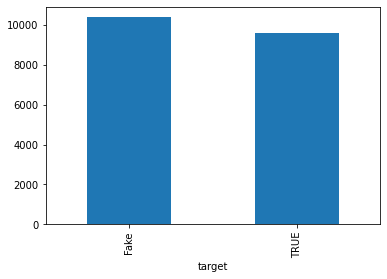

In [ ]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

In [ ]:
data.dtypes

Unnamed: 0    object
text          object
subject       object
target        object
dtype: object

In [ ]:

counts = data['target'].value_counts()
counts

Fake    10395
TRUE     9596
nan         8
Name: target, dtype: int64

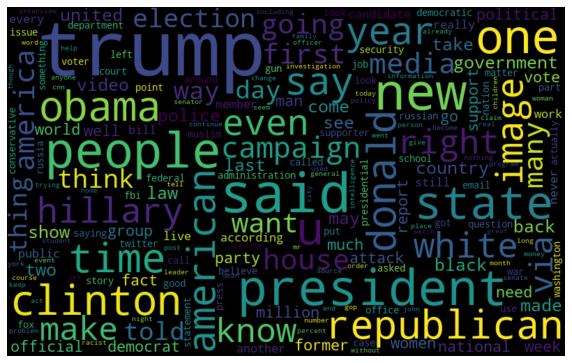

In [ ]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "Fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

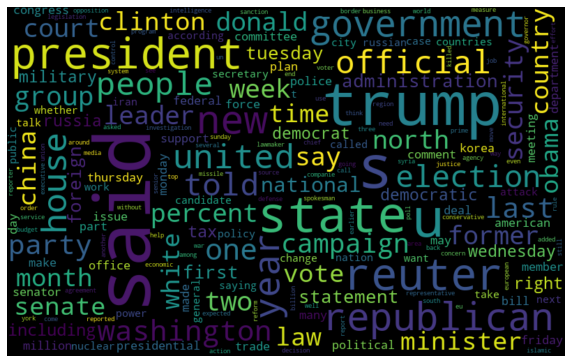

In [ ]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "TRUE"]
all_words = ' '.join([text for text in real_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

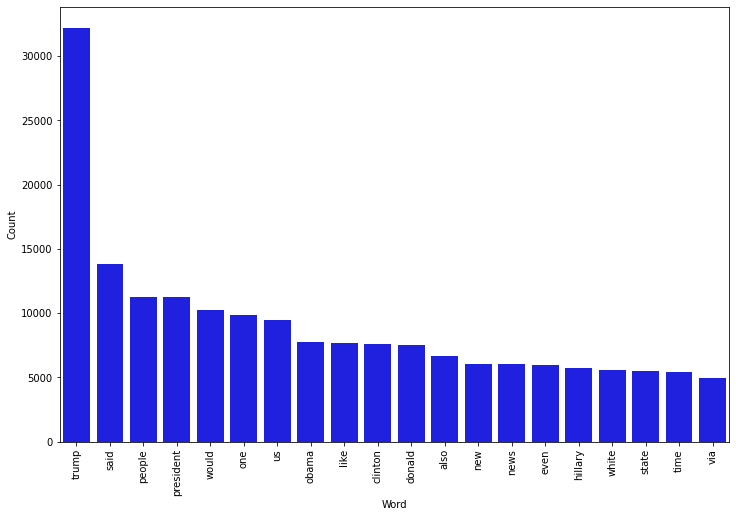

In [ ]:
# Most frequent words in fake news
counter(data[data["target"] == "Fake"], "text", 20)

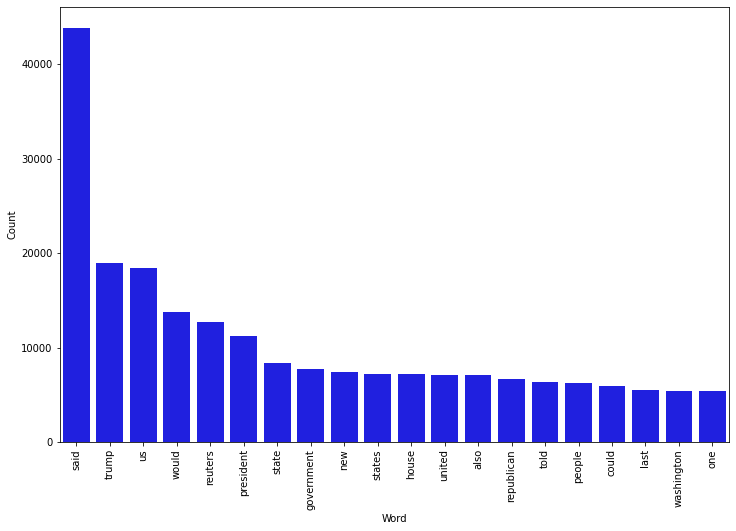

In [ ]:
# Most frequent words in real news
counter(data[data["target"] == "TRUE"], "text", 20)

## Modeling

In [ ]:
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [ ]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

# **Naive Bayes**




In [ ]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)

prediction = model.predict(X_test)
dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)

print("Accuracy:", round(accuracy_score(y_test, prediction)*100,2))
print("Precision:", round(metrics.precision_score(y_test, prediction, pos_label="TRUE")*100,2))
print("Recall:", round(metrics.recall_score(y_test, prediction, pos_label="TRUE")*100,2))
print("F1 Score:", round(metrics.f1_score(y_test, prediction, pos_label="TRUE")*100,2))

Accuracy: 94.45
Precision: 92.18
Recall: 96.68
F1 Score: 94.38


Confusion matrix, without normalization


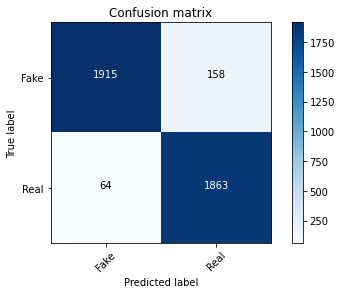

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Logistic regression**

In [ ]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)

print("Accuracy:", round(accuracy_score(y_test, prediction)*100,2))
print("Precision:", round(metrics.precision_score(y_test, prediction, pos_label="TRUE")*100,2))
print("Recall:", round(metrics.recall_score(y_test, prediction, pos_label="TRUE")*100,2))
print("F1 Score:", round(metrics.f1_score(y_test, prediction, pos_label="TRUE")*100,2))

Accuracy: 98.82
Precision: 98.5
Recall: 99.07
F1 Score: 98.78


Confusion matrix, without normalization


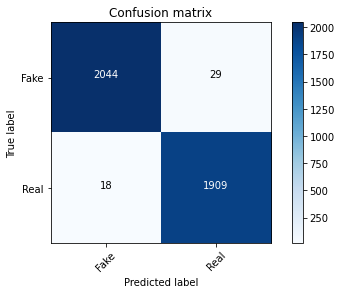

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# model = pipe.fit(["Donald Trump never became the president of United States"], ["false"])

# Accuracy
prediction = model.predict(X_test)
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)


print("Accuracy:", round(accuracy_score(y_test, prediction)*100,2))
print("Precision:", round(metrics.precision_score(y_test, prediction, pos_label="TRUE")*100,2))
print("Recall:", round(metrics.recall_score(y_test, prediction, pos_label="TRUE")*100,2))
print("F1 Score:", round(metrics.f1_score(y_test, prediction, pos_label="TRUE")*100,2))

# customX = ["Donald Trump never became the president of United States"]
# customY = ["false"]

# prediction = model.predict(customX)
# print("accuracy: {}%".format(round(accuracy_score(customY, prediction)*100,2)))

Accuracy: 99.45
Precision: 99.38
Recall: 99.48
F1 Score: 99.43


Confusion matrix, without normalization


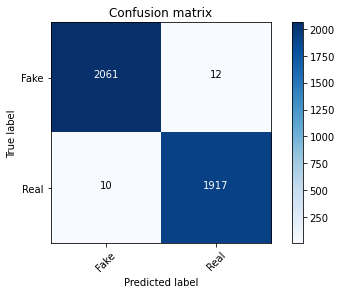

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)

print("Accuracy:", round(accuracy_score(y_test, prediction)*100,2))
print("Precision:", round(metrics.precision_score(y_test, prediction, pos_label="TRUE")*100,2))
print("Recall:", round(metrics.recall_score(y_test, prediction, pos_label="TRUE")*100,2))
print("F1 Score:", round(metrics.f1_score(y_test, prediction, pos_label="TRUE")*100,2))


Accuracy: 98.2
Precision: 97.44
Recall: 98.86
F1 Score: 98.15


Confusion matrix, without normalization


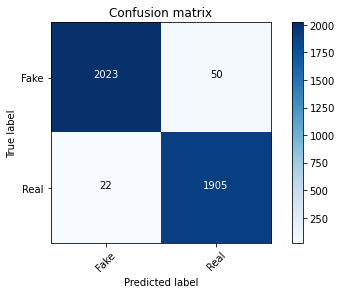

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## **SVM**

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)

dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)

print("Accuracy:", round(accuracy_score(y_test, prediction)*100,2))
print("Precision:", round(metrics.precision_score(y_test, prediction, pos_label="TRUE")*100,2))
print("Recall:", round(metrics.recall_score(y_test, prediction, pos_label="TRUE")*100,2))
print("F1 Score:", round(metrics.f1_score(y_test, prediction, pos_label="TRUE")*100,2))



Accuracy: 99.3
Precision: 98.97
Recall: 99.58
F1 Score: 99.28


Confusion matrix, without normalization


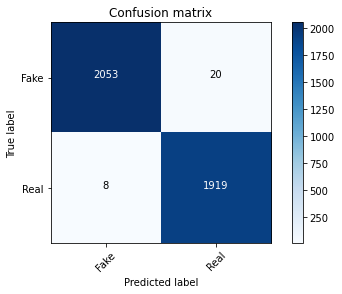

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Comparing** **Different Models**

([<matplotlib.axis.YTick at 0x7f7ac20f6f10>,
 <a list of 10 Text major ticklabel objects>)

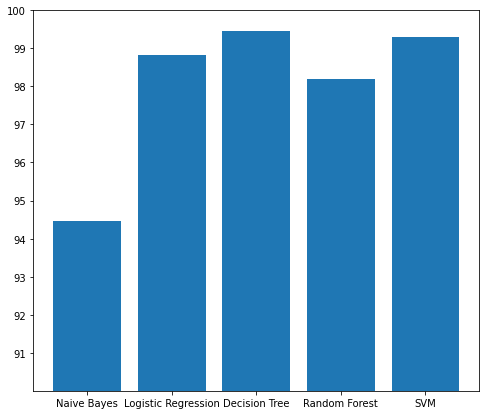

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))

In [ ]:
the end.....